# Appendix: Improving classification accuracy by addressing outliers

## Authors: 
Isidora Jankov (PhD student)  
Djordje Savic (Postdoc)

## Assistant:  
Iva Čvorović-Hajdinjak (PhD student)

## Code specification

**Reproducibility:**  
Reproducible in the SciServer Essentials 2.0 compute image if the next steps are performed:
- RLLE.py file is in the same directory as this notebook
- Install `wpca` module (https://github.com/jakevdp/wpca) by `pip install wpca`.

**Should the notebook be run on the blinded dataset?**  
This is just a demonstration of additional data analysis, so there is no need for its evaluation on the blinded dataset.

**Working with already trained models**  
Model training for this demonstration is not time consuming, so there is no need to supplement this notebook with pre-trained models.

**Notebook developed and tested on a laptop with specifications:**
- Memory: 8 GB
- Processor: Intel® Core™ i5-8250U CPU @ 1.60GHz × 8
- Graphics: Mesa Intel® UHD Graphics 620 (KBL GT2)
- Disk capacity: 256 GB
- OS Name: Ubuntu 20.04.3 LTS
- OS Type: 64-bit

**Code version:** in development phase

**Sample:** tests performed on 5 random subsamples with size of 10,000 objects (8% of the AGN DC Stripe82 Object Table when NaN values are excluded).

## Contents:

1. Introduction and motivation
2. Test on the artificial data
3. Data reading and pre-processing
4. Parameter selection and brief data exploration
5. Outlier detection: Robust LLE method
6. Comparing classification accuracy with and without outliers
7. Conclusion
8. References

## 1. Introduction and motivation

Outliers are data points which are inconsistent with the rest of the data. They can carry information about interesting anomalies, but also could represent noise. Nonetheless, they are always hindering the classification of common classes expected to be well sampled in the data, hence our motivation to address this problem.

In this notebook, we demonstrate one possible approach to outlier detection in multidimensional space as a way to obtain better Star/Galaxy/Qso class prediction accuracy from supervised machine learning models. The method is using robust statistics in order to locate and remove outliers for the purpose of getting more accurate projections resulting from nonlinear dimensionality  reduction technique called Robust Locally Linear Embedding (Robust LLE, [Chang & Yeung 2006](https://www.sciencedirect.com/science/article/abs/pii/S0031320305003353?via%3Dihub); [Roweis & Saul 2000](https://ui.adsabs.harvard.edu/abs/2000Sci...290.2323R/abstract)). LLE and Robust LLE are manifold learning methods (a type of unsupervised machine learning) and they can be useful in characterization of objects of different classes (e.g., [Vanderplas & Connolly 2009](https://ui.adsabs.harvard.edu/abs/2009AJ....138.1365V/abstract)), but also for exploration of physical properties of objects belonging in the same class (e.g., for spectral characterization of type 1 AGN, preliminary results in [Jankov et al. 2021](https://ui.adsabs.harvard.edu/abs/2021POBeo.100..241J/abstract), more detailed analysis in prep.), which is beyond the scope of this notebook. Although, we did not apply dimensionality reduction, robust outlier detection method prior to LLE is still useful for improving classification accuracy because it acknowledges the manifold hypothesis which states that high-dimensional data lies on a low dimensional manifold embedded in high dimensional space.  Real world data, such as the data provided in the AGN Data Challenge, is well approximated by this hypothesis. In other words, there is less degrees of freedom in the data than there is parameters describing the data, resulting from the constraints posed by physical laws.

The method perceives the data as a manifold where outliers have several properties:

- they are not members of large number of local neighborhoods on the manifold;
- in the neighborhoods in which they do appear, they will be far from the best-fit hyperplane.

Combining those two pieces of information, reliability score is assigned to each data point where outliers are considered to be the ones with lowest score.

Described method will be applied on 5 subsamples of the Stripe82 Object Table. For each subsample, Star/Galaxy/Qso class prediction accuracy will be evaluated on the obtained outlier-free version of the subsample and on the original subsample (with outliers) using popular supervised machine learning models, such as Support Vector Machines and Random Forest Classifier.

**Initialization of Python modules**

In [1]:
# Standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os, sys
import seaborn as sns
import time

from scipy.stats import zscore
from random import sample
from sklearn import linear_model, datasets, preprocessing, svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import RLLE # custom module

pd.set_option('display.max_columns', 1000)

## 2. Test on the artificial data

Before we apply robust outlier detection method ([Chang & Yeung, 2006](https://www.sciencedirect.com/science/article/abs/pii/S0031320305003353?via%3Dihub)) to data from the AGN Data Challenge, for clarity, we will briefly demonstrate our implementation of it using artificial data and visualize the results.

In [2]:
# Input parameters
n_points = 3000
outlier_ratio = 0.05
outlier_num = int(outlier_ratio * n_points)
k = 15

# Creating S-curve test sample
X, color_x = datasets.make_s_curve(n_points, random_state=42)

# Insert outliers by sampling random data points from the whole feature space
np.random.seed(42)
for i in range(3):
    X_space = np.linspace(X[:,i].min() - 0.2 * X[:,i].max(), X[:,i].max() + 0.2 * X[:,i].max(), 10000)
    X_outl = sample(list(X_space), outlier_num)
    X[:outlier_num,i] = X_outl

# Converting test sample to DataFrame
s_curve = pd.DataFrame(X, columns=['p1', 'p2', 'p3'])

In the next cell is the main function for outlier detection. Required input parameters are:

- the data in which we want to detect outliers
- number of neighbors ($k$) considered for each data point.

For more details see docs in RLLE.py file.

There are no consistent guidelines for selecting $k$, but it can be selected by optimizing to obtain most accurate projection when reducing dimensionality using Locally Linear Embedding algorithm (see [Jankov et al. 2020](https://publications.aob.rs/99/pdf/291-294.pdf) for the procedure). Because of the limited computational resources, we opted for empirically chosen numbers as was the case with many authors who used this method (e.g., [Vanderplas & Connolly 2009](https://ui.adsabs.harvard.edu/abs/2009AJ....138.1365V/abstract), [Daniel et al. 2011](https://ui.adsabs.harvard.edu/abs/2011AJ....142..203D/abstract), [Matijevič et al. 2012)](https://ui.adsabs.harvard.edu/abs/2012AJ....143..123M/abstract).


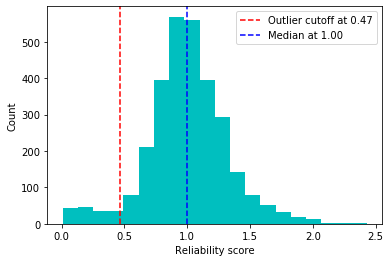

Runtime: 60.83 seconds


In [3]:
# Apply outlier detection (see RLLE.py for docs)
s_curve_new, idx, outliers, scores = RLLE.RLLE_outliers(s_curve, k, outlier_ratio = 0.05, d_out=2, metric='geodesic')

The histogram above shows how common are the points with different reliability scores, as well as the cutoff and median values. Points below cutoff are considered to be outliers.

RLLE_outliers() detected 81% of inserted outliers in s_curve


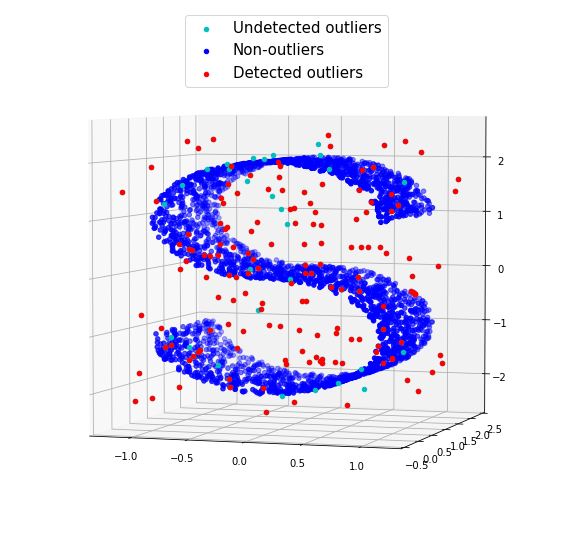

In [4]:
# Visualization (red points are *detected* outliers using this method)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(s_curve.iloc[:outlier_num, 0], s_curve.iloc[:outlier_num, 1], s_curve.iloc[:outlier_num, 2], c='c', label='Undetected outliers', depthshade=False)
ax.scatter(s_curve.iloc[outlier_num:, 0], s_curve.iloc[outlier_num:, 1], s_curve.iloc[outlier_num:, 2], c='b', label='Non-outliers')
ax.scatter(outliers.iloc[:, 0], outliers.iloc[:, 1], outliers.iloc[:, 2], c='red', alpha=1, label='Detected outliers', depthshade=False)
ax.legend(fontsize=15, loc='upper center')
ax.view_init(4, -72)

n = s_curve[:outlier_num].index.isin(outliers.index).sum()
print('RLLE_outliers() detected {:.0f}% of inserted outliers in s_curve'.format((n/outlier_num)*100))

## 3. Data reading and pre-processing

Now, let's move on to the data provided in the AGN Data Challenge.

In [5]:
# Data challenge root data dir
data_dir = "./data/"

In [6]:
# Read the object table
object_df = pd.read_parquet(os.path.join(data_dir, 's82ObjectTable.parquet'))
object_df.describe()

,ra,dec,psPm_ra,psPm_dec,psParallax,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,photoZ_pest,z,flags_u,flags_g,flags_r,flags_i,flags_z,flags_y,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNonPerio

In [7]:
# Replace highZQso with Qso for simplicity
object_df.replace({'class': {'highZQso': 'Qso'}}, inplace=True)

In [8]:
# Number of objects in each class + unlabeled
display(object_df['class'].value_counts())
print("\nNumber of unlabeled objects: {}".format(object_df['class'].isna().sum()))

Gal     213198
Star     93001
Qso      73382
Name: class, dtype: int64


Number of unlabeled objects: 57409


In [9]:
# Proper motion ()
object_df['psPm'] = np.sqrt((object_df['psPm_ra'])**2 + (object_df['psPm_dec'])**2)

## 4. Parameter selection and brief data exploration

Selection of this particular set of parameters was guided by histogram analysis of all parameters available in the Stripe82 Object Table. Subset of parameters with good separation between at least two classes (especially between star-qso and galaxy-qso) visible on histograms was selected (see the following cell with a histogram).

In [10]:
# Parameter selection

sample = object_df[['psMag_u', 'psMag_g', 'psMag_r', 'psMag_i', 'psMag_z', 'psMag_y', 
                    'extendedness_g', 'extendedness_r','extendedness_i', 'extendedness_z',
                    'lcNonPeriodic[0]_g','lcNonPeriodic[5]_g','lcNonPeriodic[5]_r','lcNonPeriodic[9]_i',
                    'lcNonPeriodic[12]_u','lcNonPeriodic[13]_u','lcNonPeriodic[14]_g','lcNonPeriodic[15]_u',
                    'lcNonPeriodic[15]_g','lcNonPeriodic[15]_r', 'lcNonPeriodic[15]_i','lcNonPeriodic[15]_z',
                    'lcNonPeriodic[21]_u', 'lcNonPeriodic[21]_g','lcNonPeriodic[23]_u','lcNonPeriodic[25]_g',
                    'lcNonPeriodic[25]_r', 'lcNonPeriodic[25]_i','lcNonPeriodic[26]_u','lcNonPeriodic[26]_g', 
                    'lcNonPeriodic[26]_r','lcNonPeriodic[26]_i',
                    'lcPeriodic[4]_i', 'lcPeriodic[4]_u','lcPeriodic[12]_g','lcPeriodic[14]_i',
                    'lcPeriodic[20]_g','lcPeriodic[28]_g', 'lcPeriodic[28]_i','lcPeriodic[29]_g','lcPeriodic[29]_r',
                    'lcPeriodic[29]_i','lcPeriodic[30]_g', 'lcPeriodic[30]_r','lcPeriodic[30]_i',
                    'stdColor_0','stdColor_1', 'stdColor_2', 'stdColor_3', 'stdColor_4',
                    'psPm',
                    'z',
                    'class']]


# Note that parameters where constant numbers appear in local neighborhoods are discarded because the Singular
# Value Decomposition did not converge in these cases. 

# The problematic parameters are: 'lcNonPeriodic[12]_g','lcNonPeriodic[28]_g', 'lcNonPeriodic[28]_r','lcNonPeriodic[28]_i', 'extendedness_u', 'lcNonPeriodic[22]_g'

# drop NaN values
sample_good_all = sample.dropna()

# drop redshift (we used it in sample selection because classification labels are more reliable for objects with
# measured spectroscopic redshift, as stated in the AGN DC docs)
sample_good_all = sample_good_all.drop('z',axis=1)

print("Parent sample with no NaN values for {} selected parameters (including class) contains {} objects.".format(sample_good_all.shape[1], sample_good_all.shape[0]))

Parent sample with no NaN values for 52 selected parameters (including class) contains 130037 objects.


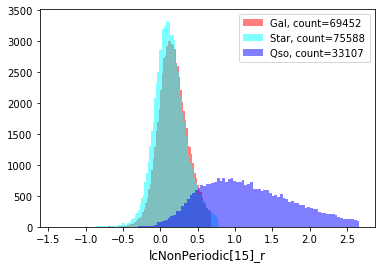

In [11]:
# Histogram example

param = 'lcNonPeriodic[15]_r'

num_bins=100

x = object_df.loc[object_df['class']=='Qso',param]
y = object_df.loc[object_df['class']=='Gal',param]
z = object_df.loc[object_df['class']=='Star',param]


plt.hist(y.loc[(y.quantile(0.0)<y) & (y<y.quantile(0.97))], num_bins, facecolor='red', alpha=0.5, label='Gal, count={}'.format((y.shape[0] - y.isna().sum())))
plt.hist(z.loc[(z.quantile(0.0)<z) & (z<z.quantile(0.97))], num_bins, facecolor='cyan', alpha=0.5, label='Star, count={}'.format((z.shape[0] - z.isna().sum())))
plt.hist(x.loc[(x.quantile(0.0)<x) & (x<x.quantile(0.97))], num_bins, facecolor='blue', alpha=0.5, label='Qso, count={}'.format((x.shape[0] - x.isna().sum())))
plt.legend()
plt.xlabel(param,size=12)
plt.show()

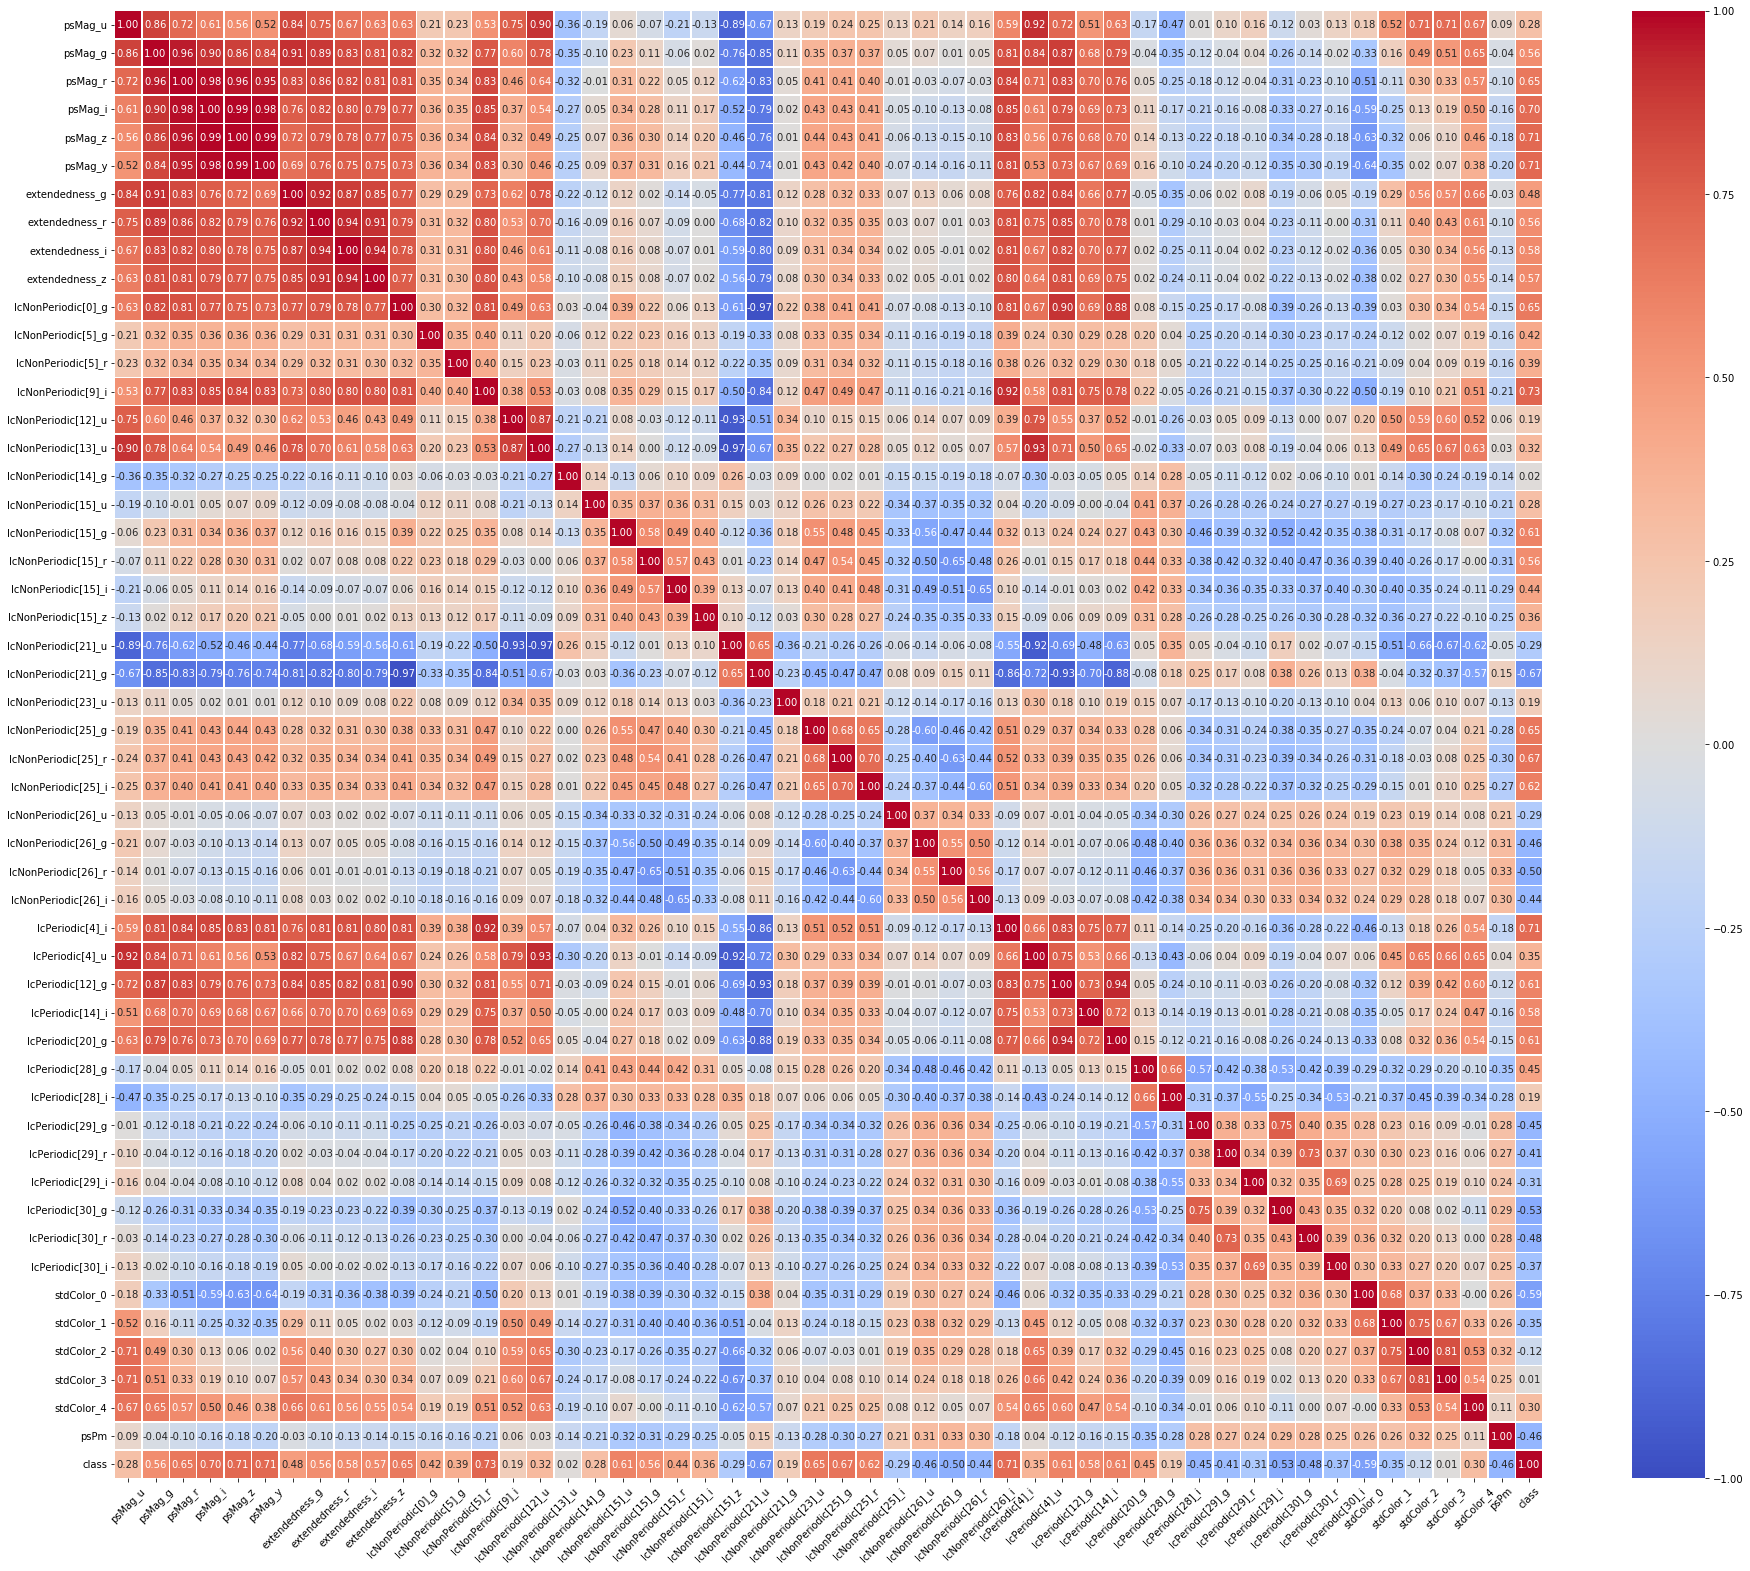

In [12]:
# Correlation matrix

# Select a smaller subsample for correlation matrix to save time
sample_good = sample_good_all.sample(n=40000, replace=False, random_state=1)
sample_good_class = sample_good.replace({'class': {'Star': 0, 'Gal': 1, 'Qso': 2}})

corr = sample_good_class.corr(method='spearman')

fig, ax = plt.subplots(figsize=(32,27))
sns.heatmap(data=corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

Notice that the `class` parameter in the correlation matrix has high correlations with many selected parameters.

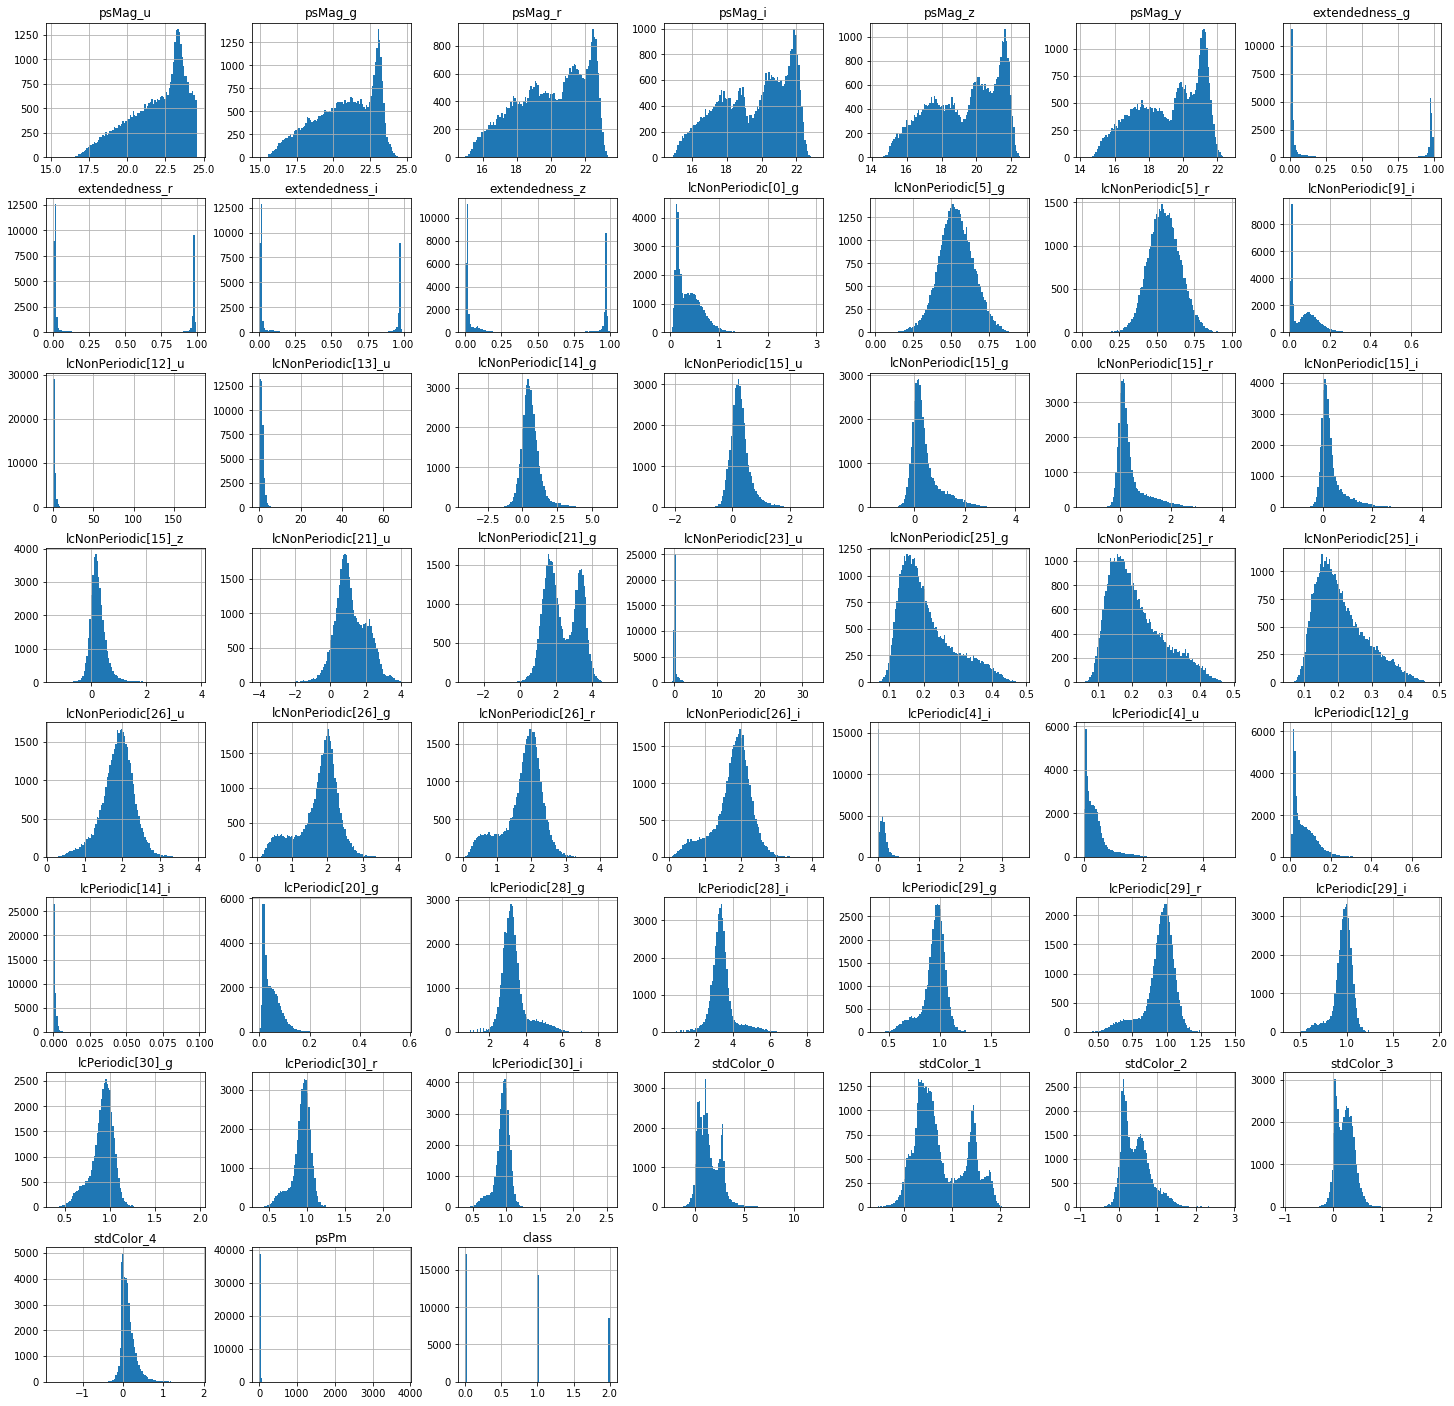

In [13]:
# Quick histograms of selected attributes
sample_good_class.hist(figsize = [25,25], bins=100)
plt.show()

## 5. Outlier detection: Robust LLE method

Finally, we apply the algorithm to detect outliers in the subsample of the AGN Data Challenge dataset. The subsample is $\sim 8\%$ of the parent sample. We have tested the code on 5 different random subsamples of the same size. As code is in the developing phase, we are working still on its improvement and parallelization in order to include larger samples for testing.

In [15]:
# Create 5 different random subsamples

norm_samples = []
samples = []
cats = []

for i in range(5):
    # Select smaller subsample from the parent sample
    sample = sample_good_all.sample(n=10000, replace=False, random_state=i, ignore_index=True)
    category = sample.pop('class')
    samples.append(sample)
    cats.append(category)
    
    # Z-score normalization before applying outlier detection
    norm_sample = sample.apply(zscore)
    norm_samples.append(norm_sample)

print("Each subsample contains {} objects described by {} parameters.".format(sample.shape[0], sample.shape[1]))

Final sample has 10000 objects described by 51 parameters.


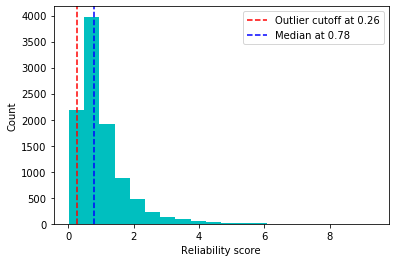

Runtime: 1524.49 seconds


In [16]:
# Find outliers: subsample 0

new_sample0, new_idx0, outliers0, scores0 = RLLE.RLLE_outliers(norm_samples[0],        # standardized input data 
                                                           k=25,               # neighborhood size                                                  
                                                           outlier_ratio=0.05, # expected perecntage of outliers in the data
                                                           d_out=10,           # output dimension
                                                           metric='geodesic')  # metric used for neighbor search

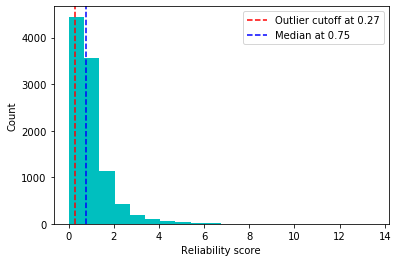

Runtime: 1337.65 seconds


In [18]:
# Find outliers: subsample 1

new_sample1, new_idx1, outliers1, scores1 = RLLE.RLLE_outliers(norm_samples[1],        # standardized input data 
                                                           k=25,               # neighborhood size                                                  
                                                           outlier_ratio=0.05, # expected perecntage of outliers in the data
                                                           d_out=10,           # output dimension
                                                           metric='geodesic')  # metric used for neighbor search

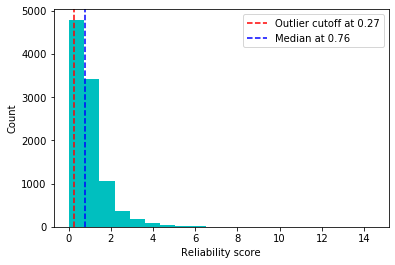

Runtime: 1300.03 seconds


In [20]:
# Find outliers: subsample 2

new_sample2, new_idx2, outliers2, scores2 = RLLE.RLLE_outliers(norm_samples[2],        # standardized input data 
                                                           k=25,               # neighborhood size                                                  
                                                           outlier_ratio=0.05, # expected perecntage of outliers in the data
                                                           d_out=10,           # output dimension
                                                           metric='geodesic')  # metric used for neighbor search

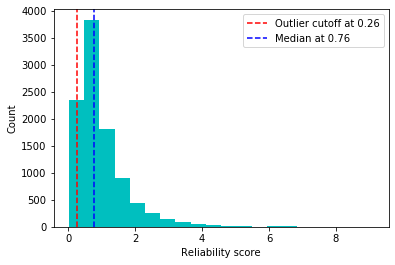

Runtime: 1325.55 seconds


In [22]:
# Find outliers: subsample 3

new_sample3, new_idx3, outliers3, scores3 = RLLE.RLLE_outliers(norm_samples[3],        # standardized input data 
                                                           k=25,               # neighborhood size                                                  
                                                           outlier_ratio=0.05, # expected perecntage of outliers in the data
                                                           d_out=10,           # output dimension
                                                           metric='geodesic')  # metric used for neighbor search

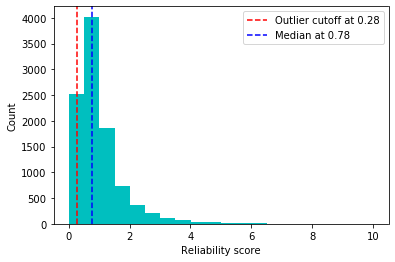

Runtime: 1320.10 seconds


In [24]:
# Find outliers: subsample 4

new_sample4, new_idx4, outliers4, scores4 = RLLE.RLLE_outliers(norm_samples[4],        # standardized input data 
                                                           k=25,               # neighborhood size                                                  
                                                           outlier_ratio=0.05, # expected perecntage of outliers in the data
                                                           d_out=10,           # output dimension
                                                           metric='geodesic')  # metric used for neighbor search

**Clarification:** best choice for $d_{\mathrm{out}}$ parameter would be intrinsic dimensionality of the data, which is unknown. We have chosen $d_{\mathrm{out}}=10$, which is $\sim5$ times smaller than the input dimensionality. The tests showed that there is no significant change in the results when trying different values in the range between 7 and 20. Again, this choice could be guided by optimizing to obtain most accurate projection when reducing dimensionality using Locally Linear Embedding algorithm, but because of the limited resources, we opted for a reasonable number obtained as mentioned above.

## 6. Comparing classification accuracy with and without outliers

In this section, we will test the Star/Galaxy/Qso classification accuracy using the five original subsamples and their outlier-free versions. The tests will be performed with Support Vector Machines and Random Forest Classifier.

In [26]:
# Functions for preparing data and applying basic supervised ML models

def prep(X,y, test_size=0.33, random_state=7):
    
    "Prepare data for model fitting: train-test split and standardization"
    
    # train-test split
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = test_size, random_state = random_state)
    
    #standardization using StandardScaler applied to X_train and then scaling X_train and X_test
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

def model_fit_predict(X_train, X_test, y_train, y_test, model='svm'):
    
    """
    Model fitting, label prediction and accuracy score calculation for either
    Support Vector Machines or Random Forest Classifier.
    """
    
    if model=='svm':    
        # performing the svm classification
        rbf = svm.SVC(kernel='rbf', C=500, decision_function_shape='ovo').fit(X_train, y_train)
        y_pred = rbf.predict(X_test)
        # confusion matrix
        plot_confusion_matrix(rbf, X_test, y_test, normalize='true', cmap='magma')
        
    elif model=='random forest':
        # Random Forest Classifier
        clf=RandomForestClassifier(n_estimators=500, criterion="entropy").fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # confusion matrix
        plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap='magma')
        
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, f1, y_pred

### 6.1. Data without outliers

**Support Vector Machines (SVM)**

In [79]:
new_samples = [new_sample0, new_sample1, new_sample2, new_sample3, new_sample4]
new_idxs = [new_idx0, new_idx1, new_idx2, new_idx3, new_idx4]

Sample 0: Accuracy for rbf SVM (no outliers): 98.21%
Sample 1: Accuracy for rbf SVM (no outliers): 98.25%
Sample 2: Accuracy for rbf SVM (no outliers): 98.05%
Sample 3: Accuracy for rbf SVM (no outliers): 97.96%
Sample 4: Accuracy for rbf SVM (no outliers): 98.21%


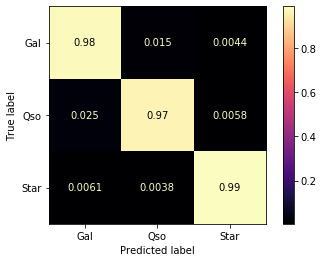

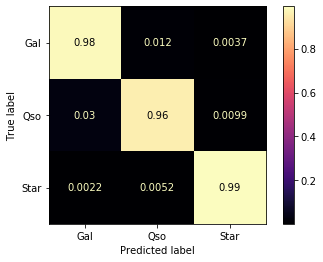

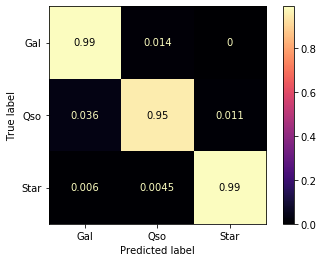

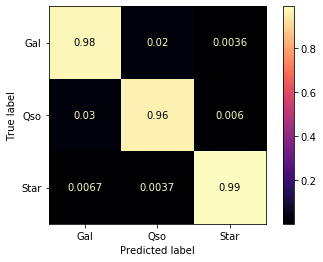

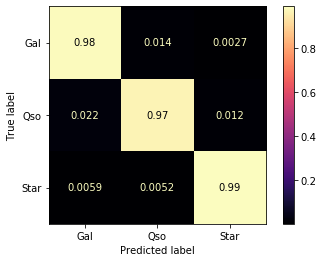

In [80]:
acc_rbf1 = []

i = 0
for s, idx, c in zip(new_samples, new_idxs, cats):

    # Data with removed outliers
    y = c.iloc[idx]
    X = s

    #print(X.shape, y.shape)

    # Prepare data for model fitting
    X_train, X_test, y_train, y_test = prep(X,y)
    accuracy_rbf1, f1, y_pred = model_fit_predict(X_train, X_test, y_train, y_test, model='svm')
    print('Sample {}: Accuracy for rbf SVM (no outliers): {:.2f}%'.format(i, accuracy_rbf1*100))
    acc_rbf1.append(accuracy_rbf1)
    #print('Sample {}: F1 rbf SVM (no outliers): {:.2f}%'.format(i, f1*100))
    i = i+1

**Random Forest Classifier**

Sample 0: Accuracy for Random Forest Classifier (no outliers): 98.41%
Sample 1: Accuracy for Random Forest Classifier (no outliers): 98.15%
Sample 2: Accuracy for Random Forest Classifier (no outliers): 98.69%
Sample 3: Accuracy for Random Forest Classifier (no outliers): 98.41%
Sample 4: Accuracy for Random Forest Classifier (no outliers): 98.34%


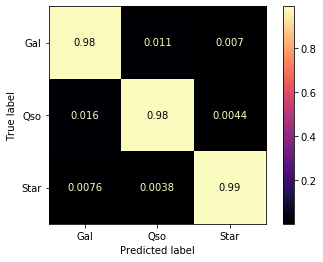

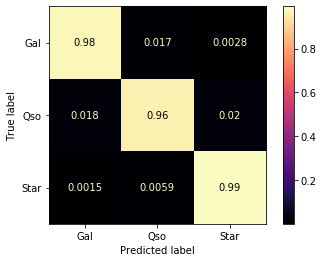

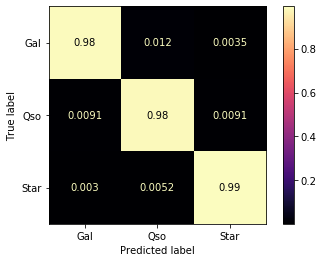

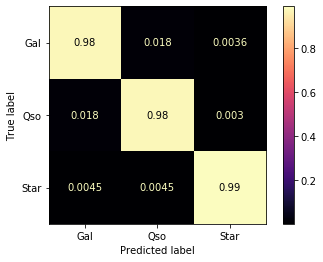

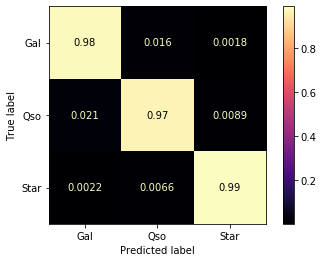

In [81]:
acc_clf1 = []

i = 0
for s, idx, c in zip(new_samples, new_idxs, cats):

    # Data with removed outliers
    y = c.iloc[idx]
    X = s

    #print(X.shape, y.shape)

    # Prepare data for model fitting
    X_train, X_test, y_train, y_test = prep(X,y)
    accuracy_clf1, f1, y_pred = model_fit_predict(X_train, X_test, y_train, y_test, model='random forest')
    acc_clf1.append(accuracy_clf1)
    print('Sample {}: Accuracy for Random Forest Classifier (no outliers): {:.2f}%'.format(i, accuracy_clf1*100))
    #print('Sample {}: F1 rbf SVM (no outliers): {:.2f}%'.format(i, f1*100))
    i = i+1

### 6.2. Original data (with outliers)

**Support Vector Machines**

Sample 0: Accuracy for rbf SVM (with outliers): 97.82%
Sample 1: Accuracy for rbf SVM (with outliers): 97.79%
Sample 2: Accuracy for rbf SVM (with outliers): 97.85%
Sample 3: Accuracy for rbf SVM (with outliers): 97.73%
Sample 4: Accuracy for rbf SVM (with outliers): 98.24%


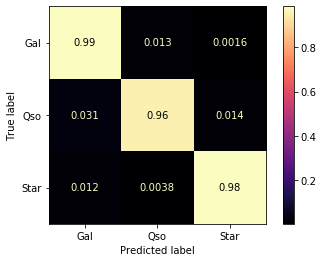

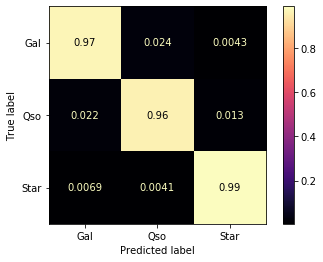

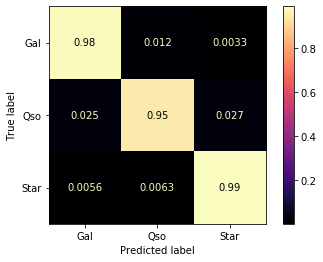

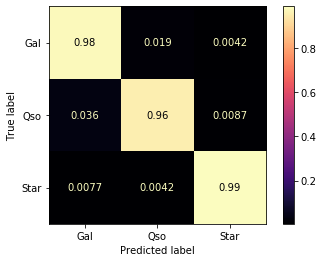

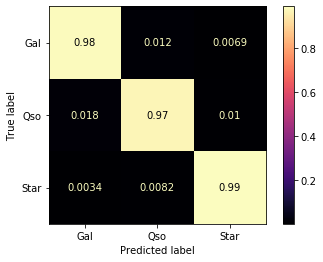

In [82]:
acc_rbf2 = []

i = 0
for s, c in zip(samples, cats):

    # Data with removed outliers
    y = c
    X = s

    #print(X.shape, y.shape)

    # Prepare data for model fitting
    X_train, X_test, y_train, y_test = prep(X,y)
    accuracy_rbf2, f1, y_pred = model_fit_predict(X_train, X_test, y_train, y_test, model='svm')
    print('Sample {}: Accuracy for rbf SVM (with outliers): {:.2f}%'.format(i, accuracy_rbf2*100))
    acc_rbf2.append(accuracy_rbf2)
    #print('Sample {}: F1 rbf SVM (no outliers): {:.2f}%'.format(i, f1*100))
    i = i+1

**Random Forest Classifier**

Sample 0: Accuracy for Random Forest Classifier (with outliers): 98.00%
Sample 1: Accuracy for Random Forest Classifier (with outliers): 97.79%
Sample 2: Accuracy for Random Forest Classifier (with outliers): 97.94%
Sample 3: Accuracy for Random Forest Classifier (with outliers): 98.06%
Sample 4: Accuracy for Random Forest Classifier (with outliers): 98.03%


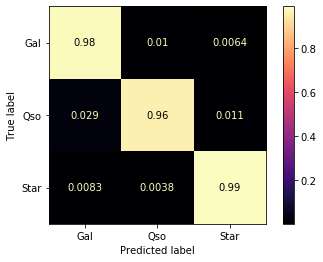

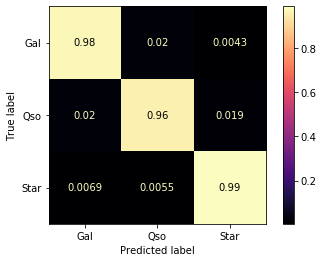

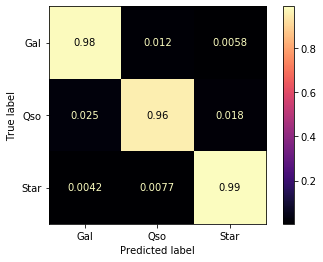

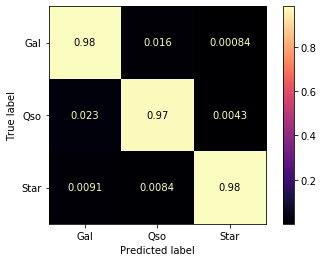

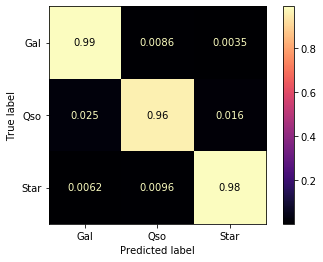

In [83]:
acc_clf2 = []

i = 0
for s, c in zip(samples, cats):

    # Data with removed outliers
    y = c
    X = s

    #print(X.shape, y.shape)

    # Prepare data for model fitting
    X_train, X_test, y_train, y_test = prep(X,y)
    accuracy_clf2, f1, y_pred = model_fit_predict(X_train, X_test, y_train, y_test, model='random forest')
    print('Sample {}: Accuracy for Random Forest Classifier (with outliers): {:.2f}%'.format(i, accuracy_clf2*100))
    acc_clf2.append(accuracy_clf2)
    #print('Sample {}: F1 rbf SVM (no outliers): {:.2f}%'.format(i, f1*100))
    i = i+1

### Did accuracy score improve as a result of outlier removal?

In [85]:
delta_rbfs = []
delta_clfs = []
for i in range(5):
    delta_rbf = (acc_rbf1[i] - acc_rbf2[i])*100
    delta_clf = (acc_clf1[i] - acc_clf2[i])*100
    delta_rbfs.append(delta_rbf)
    delta_clfs.append(delta_clf)
    
print('In the case of selected 5 subsamples, on average, removing outliers improved accuracy score by:\n')
print('{:.2f}% for SVM'.format(np.asarray(delta_rbfs).mean()))
print('{:.2f}% for Random Forest'.format(np.asarray(delta_clfs).mean()))

In the case of selected 5 subsamples, on average, removing outliers improved accuracy score by:

0.25% for SVM
0.44% for Random Forest


## 7. Conclusion

This notebook demonstrated the use of the multidimensional outlier detection method which relies on the manifold hypothesis. It was shown how the method behaves on the artificial data and on the AGN Data Challenge Stripe82 Object Table with pre-selected parameters for Star/Galaxy/Qso classification. When outliers are removed, basic supervised machine learning models, such as SVM and Random Forest Classifier, gave somewhat better predictions. Our understanding is that even small improvements in the prediction accuracy could be valuable when having very high baseline accuracy and large number of objects in the sample. Additionally, this method reveals a subsample of outliers which could be further investigated to improve our understanding of the data. The method is very computationally demanding which motivates us to develop a parallelized version of the code.

## 8. References

Chang, H., Yeung, D. 2006, Pattern Recognition, 39, 1053-1065  
Daniel, S. F., et al. 2011, The Astronomical Journal, 142, 203  
Roweis, S. T., Saul, L. K. 2000, Science, 290, 2323-2326  
Jankov, I., Ilic, D., Kovacevic, A., 2020, Publications of the Astronomical Observatory of Belgrade, 99, 291-294  
Jankov, I., Ilic, D., Kovacevic, A., 2021, Publications of the Astronomical Observatory of Belgrade, 100, 241-246  
Matijevic G., et al. 2012, The Astronomical Journal, 143, 123  
Vanderplas, J., Connolly, A. 2009, The Astronomical Journal, 138, 1365-1379  